# Cell Analysis Pipeline - Interactive Notebook

This notebook runs the complete cell analysis pipeline step by step using PyImageJ and our custom Python modules.

## Pipeline Steps:
1. **Configuration** - Set sample parameters
2. **Initialize PyImageJ** - Load ImageJ environment
3. **Preprocessing** - Run ImageJ macro to generate raw/mask images
4. **Segmentation** - Watershed segmentation to identify cells
5. **Padding** - Extract masked cells and pad to square format
6. **Filtering** - Detect cut-off cells
7. **Manual Review** - GUI for quality control
8. **Load ROIs** - Load ROIs into ImageJ
9. **Extract Channels** - Measure fluorescence in all channels

## Cell 1: Installation & Imports

Run this cell first to install dependencies and import modules.

In [ ]:
# Install dependencies (uncomment if needed)
# !pip install pyimagej numpy opencv-python pillow scikit-image scipy pandas

import imagej
import numpy as np
import pandas as pd
from pathlib import Path

# Import our custom pipeline modules
import improved_pipeline.segment_cells_watershed as segment_cells_watershed
import pad_raw_crops
import filter_bad_cells
import manual_cell_reviewer
import imagej_functions
import extract_roi_crops
import cv2
print("✓ All modules imported successfully!")

# Initialize default PARAMS (will be overwritten by config cell)
# Segmentation method selection
SEGMENTATION_METHOD = 'cellpose'  # Options: 'cellpose' or 'watershed'

PARAMS = {
    'min_distance': 12,
    'min_size': 500,
    'max_size': 9000,
    'cellpose_model': 'cyto2',
    'cellpose_diameter': None,
    'cellpose_flow_threshold': 0.4,
    'cellpose_cellprob_threshold': 0.0,
    'cellpose_use_gpu': True,
    'consecutive_threshold': 20,
    'target_size': 64
}
print("✓ Default PARAMS initialized (run config cell to customize)")


✓ All modules imported successfully!
✓ Default PARAMS initialized (run config cell to customize)


In [17]:
# Import Cellpose segmentation module (optional - for deep learning segmentation)
try:
    import segment_cells_cellpose
    CELLPOSE_AVAILABLE = True
    print("✓ Cellpose module imported successfully!")
except ImportError as e:
    CELLPOSE_AVAILABLE = False
    print(f"⚠️  Cellpose not available: {e}")
    print("   Install with: pip install cellpose")
    print("   Falling back to watershed segmentation")

✓ Cellpose module imported successfully!


In [18]:
# ============================================================================
# CONFIGURATION 
# ============================================================================

# Segmentation method
SEGMENTATION_METHOD = 'cellpose'  # Options: 'cellpose' or 'watershed'

# Sample to process
BASE_PATH = "/Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10"
SAMPLE_FOLDER = "sample3"  # Options: "sample1", "sample2", "sample3"
IMAGE_NUMBER = "2"         # Options: "1", "2", "3", "4", etc.

# Pipeline parameters
PARAMS = {
    # Segmentation - Watershed
    'min_distance': 12,
    'min_size': 50,
    'max_size': 9000,
    
    # Segmentation - Cellpose (deep learning)
    'cellpose_model': 'cyto2',        # Options: 'cyto2', 'nuclei', 'cpsam'
    'cellpose_diameter': None,        # Auto-detect if None
    'cellpose_flow_threshold': 0.4,
    'cellpose_cellprob_threshold': -6.0,
    'cellpose_use_gpu': True,
    
    # Filtering
    'consecutive_threshold': 20,
    
    # Padding
    'target_size': 64
}

print("Configuration:")
print(f"  Sample: {SAMPLE_FOLDER}/{IMAGE_NUMBER}")
print(f"  Base path: {BASE_PATH}")
print(f"  Parameters: {PARAMS}")

Configuration:
  Sample: sample3/2
  Base path: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10
  Parameters: {'min_distance': 12, 'min_size': 50, 'max_size': 9000, 'cellpose_model': 'cyto2', 'cellpose_diameter': None, 'cellpose_flow_threshold': 0.4, 'cellpose_cellprob_threshold': -6.0, 'cellpose_use_gpu': True, 'consecutive_threshold': 20, 'target_size': 64}


## Cell 3: Initialize PyImageJ

**Note:** This may take 1-2 minutes on first run while downloading Java libraries.

In [4]:
print("Initializing ImageJ with Fiji (this may take 1-2 minutes on first run)...")
print("Downloading Fiji components if needed...")

# Initialize with Fiji to enable macro support
ij = imagej.init('sc.fiji:fiji')

print(f"✓ ImageJ version: {ij.getVersion()}")
print("✓ PyImageJ ready with macro support!")

Initializing ImageJ with Fiji (this may take 1-2 minutes on first run)...
✓ ImageJ version: 2.17.0/1.54p
✓ PyImageJ ready with macro support!


## Cell 4: Step 0 - Preprocessing (ImageJ Macro)

**Optional:** Run the preprocessing macro to generate `*_raw.jpg` and `*_mask.jpg` files.

Skip this if you've already run `process_actin_fitc.ijm` manually.

In [5]:
print("="*60)
print("STEP 0: PREPROCESSING")
print("="*60)

result = imagej_functions.preprocess_actin(
    sample_folder=SAMPLE_FOLDER,
    image_number=IMAGE_NUMBER,
    base_path=BASE_PATH,
    ij=ij,
    verbose=True
)

if result['success']:
    print(f"\n✓ Raw file: {result['raw_file']}")
    print(f"✓ Mask file: {result['mask_file']}")
else:
    print(f"\n✗ Error: {result['error']}")

Operating in headless mode - the original ImageJ will have limited functionality.


STEP 0: PREPROCESSING

IMAGEJ: PREPROCESSING
Sample: sample2/2
Running preprocessing macro...
Opened original: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/Actin-FITC.tif
Auto-thresholded duplicate created
File prefix: CLLSaSa_07292025_1to10_40min_1_02
Image directory: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/
Step 1: Saving raw image...
Saved raw to: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/CLLSaSa_07292025_1to10_40min_1_02_raw.jpg
Step 2: Creating mask...
Saved mask to: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/CLLSaSa_07292025_1to10_40min_1_02_mask.jpg

✅ Macro completed successfully!
✓ Preprocessing complete
  Raw: CLLSaSa_07292025_1to10_40min_1_02_raw.jpg
  Mask: CLLSaSa_07292025_1to10_40min_1_02_mask.jpg

✓ Raw file: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/CLLSaSa_07292025_1to10_40min_1_02_raw.jpg
✓ Ma

## Cell 5-alt: Step 1 - Cell Segmentation with Cellpose (Alternative)

**Use Cellpose deep learning model for cell segmentation instead of watershed.**

### Benefits:
- Better boundary detection with deep learning
- Handles complex/irregular cell shapes
- Pre-trained on thousands of cell images
- Auto-detects cell diameter

### Output Folders (separate from watershed):
- `cell_rois_cellpose/` - ROI masks
- `raw_crops_cellpose/` - Raw cell crops
- `original_image_cellpose.tif` - Reference image

**Note:** Requires `pip install cellpose`. First run will download the model (~100-200MB).

In [6]:
if SEGMENTATION_METHOD != 'cellpose':
    print("⏭️  Skipping Cellpose segmentation (SEGMENTATION_METHOD = '{0}')".format(SEGMENTATION_METHOD))
elif not CELLPOSE_AVAILABLE:
    print("⚠️  Cellpose not available. Please install with: pip install cellpose")
    print("   Or change SEGMENTATION_METHOD to 'watershed'")
else:
    print("\n" + "="*60)
    print("STEP 1: CELLPOSE CELL SEGMENTATION")
    print("="*60)

    result = segment_cells_cellpose.segment_cells_cellpose(
        sample_folder=SAMPLE_FOLDER,
        image_number=IMAGE_NUMBER,
        base_path=BASE_PATH,
        model_type=PARAMS['cellpose_model'],
        diameter=PARAMS['cellpose_diameter'],
        flow_threshold=PARAMS['cellpose_flow_threshold'],
        cellprob_threshold=PARAMS['cellpose_cellprob_threshold'],
        min_size=PARAMS['min_size'],
        max_size=PARAMS['max_size'],
        use_gpu=PARAMS['cellpose_use_gpu'],
        verbose=True
    )

    if result['success']:
        print(f"\n✓ Segmented {result['num_cells']} cells with Cellpose")
        print(f"  ROI dir: {result['roi_dir']}")
        print(f"  Raw crops dir: {result['raw_crops_dir']}")
    else:
        print(f"\n✗ Error: {result['error']}")

model_type argument is not used in v4.0.1+. Ignoring this argument...



STEP 1: CELLPOSE CELL SEGMENTATION
CELLPOSE CELL SEGMENTATION PIPELINE
Sample: sample2/2
Base directory: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2

Loading images...
  Raw: CLLSaSa_07292025_1to10_40min_1_02_raw.jpg
  Mask: CLLSaSa_07292025_1to10_40min_1_02_mask.jpg
  Loaded image: (1002, 1004)
  Loaded mask: (1002, 1004)

Initializing Cellpose model: cyto2
  GPU enabled: True
Applied Cellpose normalization
Running Cellpose segmentation...
  Diameter: auto-detect
  Flow threshold: 0.4
  Cell probability threshold: -6.0
  Detected diameter: 30.0 pixels
  Found 19 initial masks
  After size filtering (50-9000 pixels): 14 cells

Exporting cell ROIs...
  Exported 14 cell ROIs to: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/cell_rois

Exporting raw crops...
  Exported 14 raw crops to: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/raw_crops

CELLPOSE SEGMENTATION COMPLETE

✓ Segmented 14 cel

if SEGMENTATION_METHOD != 'watershed':
    print("⏭️  Skipping Watershed segmentation (SEGMENTATION_METHOD = '{0}')".format(SEGMENTATION_METHOD))
else:
    print("\n" + "="*60)
    print("STEP 1: CELL SEGMENTATION (WATERSHED)")
    print("="*60)

    result = segment_cells.segment_cells(
        sample_folder=SAMPLE_FOLDER,
        image_number=IMAGE_NUMBER,
        base_path=BASE_PATH,
        min_distance=PARAMS['min_distance'],
        min_size=PARAMS['min_size'],
        max_size=PARAMS['max_size'],
        verbose=True
    )

    if result['success']:
        print(f"\n✓ Segmented {result['num_cells']} cells")
        print(f"  ROI dir: {result['roi_dir']}")
        print(f"  Raw crops dir: {result['raw_crops_dir']}")
    else:
        print(f"\n✗ Error: {result['error']}")

✓ Visualization complete: 14 cells segmented


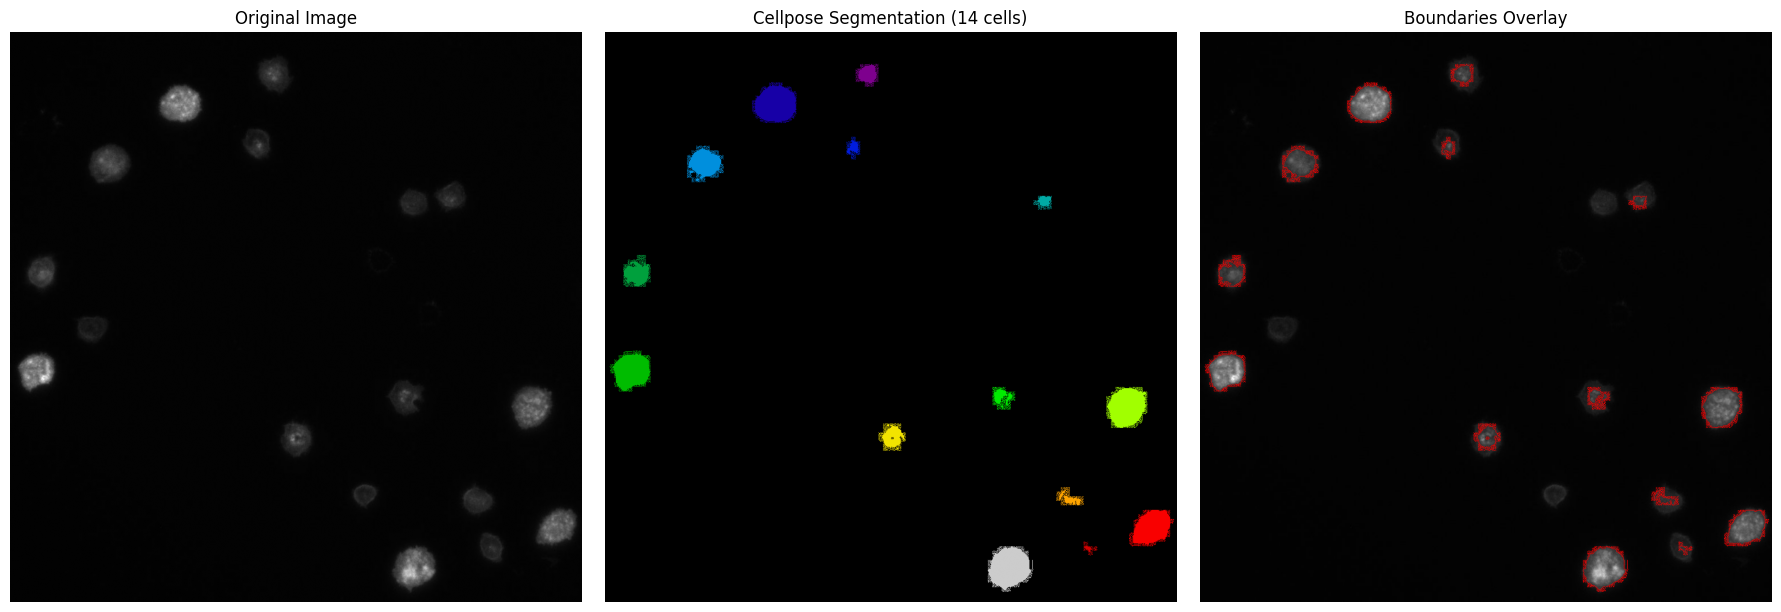

In [7]:
# Visualize segmentation results with boundaries
if SEGMENTATION_METHOD == 'cellpose':
    import matplotlib.pyplot as plt
    from pathlib import Path

    # Check if segmentation outputs exist
    base_dir = f"{BASE_PATH}/{SAMPLE_FOLDER}/{IMAGE_NUMBER}"
    roi_dir = Path(base_dir) / "cell_rois"

    if roi_dir.exists():
        from PIL import Image
        import numpy as np
        
        # Load original image
        raw_path = list(Path(base_dir).glob("*_raw.jpg"))[0]
        raw_img = np.array(Image.open(raw_path).convert('L'))
        
        # Load all ROI masks and combine
        roi_files = sorted(roi_dir.glob("*.tif"))
        combined_mask = np.zeros_like(raw_img)
        
        for i, roi_file in enumerate(roi_files):
            roi_mask = np.array(Image.open(roi_file).convert('L'))
            combined_mask[roi_mask > 0] = i + 1
        
        # Create visualization with boundaries
        from skimage.segmentation import find_boundaries
        boundaries = find_boundaries(combined_mask, mode='inner')
        
        # Overlay boundaries on raw image
        overlay = np.stack([raw_img] * 3, axis=-1)
        overlay[boundaries] = [255, 0, 0]  # Red boundaries
        
        # Display
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        axes[0].imshow(raw_img, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(combined_mask, cmap='nipy_spectral')
        axes[1].set_title(f'Cellpose Segmentation ({len(roi_files)} cells)')
        axes[1].axis('off')
        
        axes[2].imshow(overlay)
        axes[2].set_title('Boundaries Overlay')
        axes[2].axis('off')
        
        plt.tight_layout()
        
        print(f"✓ Visualization complete: {len(roi_files)} cells segmented")
    else:
        print(f"⚠️  No segmentation outputs found in {roi_dir}")
        print("   Please run Cell 5-alt (Cellpose segmentation) first.")
else:
    print(f"⏭️  Skipping visualization (SEGMENTATION_METHOD = '{SEGMENTATION_METHOD}')")

## Visualize Cellpose Segmentation Results

View the segmentation overlay to verify cell detection quality.

## Cell 5b: Extract ROI Crops

Extract actual cell images from original Actin-FITC using ROI masks (non-square, exact bounding box).

In [8]:
print("\n" + "="*60)
print("EXTRACT ROI CROPS FROM TIF")
print("="*60)

result = extract_roi_crops.extract_roi_crops(
    sample_folder=SAMPLE_FOLDER,
    image_number=IMAGE_NUMBER,
    base_path=BASE_PATH,
    source_image="Actin-FITC.tif",
    output_dir_name="roi_crops_tif",
    verbose=True
)

if result['success']:
    print(f"\n✓ Extracted {result['num_extracted']} cell crops from TIF")
    print(f"  Output dir: {result['output_dir']}")
else:
    print(f"\n✗ Error: {result['error']}")


EXTRACT ROI CROPS FROM TIF
EXTRACT ROI CROPS FROM ORIGINAL IMAGE
Sample: sample2/2
Source image: Actin-FITC.tif
Output directory: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/roi_crops_tif

Loading source image: Actin-FITC.tif
  Image shape: (1002, 1004)
  Image dtype: uint16

Found 14 ROI masks to process

Processing cell_01.tif...
  ✓ Saved: cell_01_crop.tif (shape: (40, 40))
Processing cell_02.tif...
  ✓ Saved: cell_02_crop.tif (shape: (72, 78))
Processing cell_03.tif...
  ✓ Saved: cell_03_crop.tif (shape: (40, 24))
Processing cell_04.tif...
  ✓ Saved: cell_04_crop.tif (shape: (64, 64))
Processing cell_05.tif...
  ✓ Saved: cell_05_crop.tif (shape: (24, 32))
Processing cell_06.tif...
  ✓ Saved: cell_06_crop.tif (shape: (56, 48))
Processing cell_07.tif...
  ✓ Saved: cell_07_crop.tif (shape: (72, 72))
Processing cell_08.tif...
  ✓ Saved: cell_08_crop.tif (shape: (40, 40))
Processing cell_09.tif...
  ✓ Saved: cell_09_crop.tif (shape: (72, 72))
Processin

## Cell 5c: Extract ROI Crops as PNG

Extract cell images as PNG with transparent background (great for viewing in Preview).

In [9]:
print("\n" + "="*60)
print("EXTRACT ROI CROPS AS PNG (WITH TRANSPARENCY)")
print("="*60)

# Find the raw JPG file
import glob
base_dir_path = f"{BASE_PATH}/{SAMPLE_FOLDER}/{IMAGE_NUMBER}"
raw_jpg_files = glob.glob(f"{base_dir_path}/*_raw.jpg")

if raw_jpg_files:
    raw_jpg = raw_jpg_files[0].split("/")[-1]
    print(f"Using: {raw_jpg}")
    
    result = extract_roi_crops.extract_roi_crops(
        sample_folder=SAMPLE_FOLDER,
        image_number=IMAGE_NUMBER,
        base_path=BASE_PATH,
        source_image=raw_jpg,
        output_dir_name="roi_crops_whiteBg",
        use_transparency=True,
        verbose=True
    )
    
    if result['success']:
        print(f"\n✓ Extracted {result['num_extracted']} cell crops as PNG with transparency")
        print(f"  Output dir: {result['output_dir']}")
    else:
        print(f"\n✗ Error: {result['error']}")
else:
    print("✗ No raw JPG file found. Run preprocessing first!")


EXTRACT ROI CROPS AS PNG (WITH TRANSPARENCY)
Using: CLLSaSa_07292025_1to10_40min_1_02_raw.jpg
EXTRACT ROI CROPS FROM ORIGINAL IMAGE
Sample: sample2/2
Source image: CLLSaSa_07292025_1to10_40min_1_02_raw.jpg
Output directory: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/roi_crops_whiteBg

Loading source image: CLLSaSa_07292025_1to10_40min_1_02_raw.jpg
  Image shape: (1002, 1004)
  Image dtype: uint8

Found 14 ROI masks to process

Processing cell_01.tif...
  ✓ Saved: cell_01_crop.png (shape: (40, 40, 4))
Processing cell_02.tif...
  ✓ Saved: cell_02_crop.png (shape: (72, 78, 4))
Processing cell_03.tif...
  ✓ Saved: cell_03_crop.png (shape: (40, 24, 4))
Processing cell_04.tif...
  ✓ Saved: cell_04_crop.png (shape: (64, 64, 4))
Processing cell_05.tif...
  ✓ Saved: cell_05_crop.png (shape: (24, 32, 4))
Processing cell_06.tif...
  ✓ Saved: cell_06_crop.png (shape: (56, 48, 4))
Processing cell_07.tif...
  ✓ Saved: cell_07_crop.png (shape: (72, 72, 4))
Processi

## Cell 5d: Extract ROI Crops from JPG

Extract cell images from JPG with white background for easy viewing.

In [10]:
print("\n" + "="*60)
print("EXTRACT ROI CROPS FROM JPG (WHITE BACKGROUND)")
print("="*60)

# Find the raw JPG file
import glob
import numpy as np
from PIL import Image

base_dir_path = f"{BASE_PATH}/{SAMPLE_FOLDER}/{IMAGE_NUMBER}"
raw_jpg_files = glob.glob(f"{base_dir_path}/*_raw.jpg")

if raw_jpg_files:
    raw_jpg = raw_jpg_files[0].split("/")[-1]
    print(f"Using: {raw_jpg}")
    
    result = extract_roi_crops.extract_roi_crops(
        sample_folder=SAMPLE_FOLDER,
        image_number=IMAGE_NUMBER,
        base_path=BASE_PATH,
        source_image=raw_jpg,
        output_dir_name="roi_crops_jpg",
        use_transparency=False,
        verbose=True
    )
    
    if result['success']:
        print(f"\n✓ Extracted {result['num_extracted']} cell crops from JPG")
        print(f"  Output dir: {result['output_dir']}")
    else:
        print(f"\n✗ Error: {result['error']}")
else:
    print("✗ No raw JPG file found. Run preprocessing first!")


EXTRACT ROI CROPS FROM JPG (WHITE BACKGROUND)
Using: CLLSaSa_07292025_1to10_40min_1_02_raw.jpg
EXTRACT ROI CROPS FROM ORIGINAL IMAGE
Sample: sample2/2
Source image: CLLSaSa_07292025_1to10_40min_1_02_raw.jpg
Output directory: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/roi_crops_jpg

Loading source image: CLLSaSa_07292025_1to10_40min_1_02_raw.jpg
  Image shape: (1002, 1004)
  Image dtype: uint8

Found 14 ROI masks to process

Processing cell_01.tif...
  ✓ Saved: cell_01_crop.tif (shape: (40, 40))
Processing cell_02.tif...
  ✓ Saved: cell_02_crop.tif (shape: (72, 78))
Processing cell_03.tif...
  ✓ Saved: cell_03_crop.tif (shape: (40, 24))
Processing cell_04.tif...
  ✓ Saved: cell_04_crop.tif (shape: (64, 64))
Processing cell_05.tif...
  ✓ Saved: cell_05_crop.tif (shape: (24, 32))
Processing cell_06.tif...
  ✓ Saved: cell_06_crop.tif (shape: (56, 48))
Processing cell_07.tif...
  ✓ Saved: cell_07_crop.tif (shape: (72, 72))
Processing cell_08.tif...
  ✓ Sa

## Cell 9: Step 5 - Load ROIs in ImageJ

Load all cell ROIs onto the original image in ImageJ.

In [11]:
print("\n" + "="*60)
print("STEP 5: LOAD ROIS IN IMAGEJ")
print("="*60)

result = imagej_functions.load_rois(
    sample_folder=SAMPLE_FOLDER,
    image_number=IMAGE_NUMBER,
    base_path=BASE_PATH,
    ij=ij,
    verbose=True
)

if result['success']:
    print(f"\n✓ Loaded {result['num_rois']} ROIs")
else:
    print(f"\n✗ Error: {result['error']}")


STEP 5: LOAD ROIS IN IMAGEJ

IMAGEJ: LOAD ROIS
Sample: sample2/2
Loading ROIs...
Loaded 14 ROIs
✓ Loaded 14 ROIs

✓ Loaded 14 ROIs


## Cell 10: Step 6 - Extract Channel Measurements

Measure fluorescence intensity in all channels for each cell ROI.

In [12]:
print("\n" + "="*60)
print("STEP 6: EXTRACT CHANNEL MEASUREMENTS")
print("="*60)

result = imagej_functions.extract_channel_measurements(
    sample_folder=SAMPLE_FOLDER,
    image_number=IMAGE_NUMBER,
    base_path=BASE_PATH,
    ij=ij,
    verbose=True
)

if result['success']:
    print(f"\n✓ Extracted {len(result['measurement_files'])} measurement files")
else:
    print(f"\n✗ Error: {result['error']}")


STEP 6: EXTRACT CHANNEL MEASUREMENTS

IMAGEJ: EXTRACT CHANNEL MEASUREMENTS
Sample: sample2/2
Found 14 ROIs
Found 4 channel images: actin-fitc, cd4-percp, cd45ra-af647, ccr7-pe
Total measurements to extract: 56

Extracting measurements...
Found 14 ROI masks

--- Processing Actin-FITC ---
  Processing ROI 1/14: cell_01.tif
    Opened ROI mask, ID: -8
    Created selection
    Restored selection on channel image
 	Area	Mean	StdDev	Min	Max	X	Y	Circ.	IntDen	RawIntDen	AR	Round	Solidity
1	41.520	3260.042	794.467	1315	5992	92.245	14.889	0.040	135356.960	3383924	1.065	0.939	0.716
    Measured, nResults = 1
    ✓ Cell 1: area=41.52, mean=3260.0424
    Closed ROI mask
  Processing ROI 2/14: cell_02.tif
    Opened ROI mask, ID: -9
    Created selection
    Restored selection on channel image
 	Area	Mean	StdDev	Min	Max	X	Y	Circ.	IntDen	RawIntDen	AR	Round	Solidity
1	163.240	5663.456	2063.411	580	12329	59.909	25.372	0.066	924502.560	23112564	1.127	0.888	0.861
    Measured, nResults = 1
    ✓ Cell 2:

## Cell 6: Step 2 - Pad Masked Cells

Extract cells using ROI masks and pad to square format.

In [13]:
print("\n" + "="*60)
print("STEP 2: PAD MASKED CELLS")
print("="*60)

result = pad_raw_crops.pad_masked_cells(
    sample_folder=SAMPLE_FOLDER,
    image_number=IMAGE_NUMBER,
    base_path=BASE_PATH,
    target_size=PARAMS['target_size'],
    verbose=True
)

if result['success']:
    print(f"\n✓ Padded {result['num_padded']} cells to {PARAMS['target_size']}x{PARAMS['target_size']}")
    print(f"  Output dir: {result['output_dir']}")
else:
    print(f"\n✗ Error: {result['error']}")


STEP 2: PAD MASKED CELLS
PAD MASKED CELLS TO SQUARE
Sample: sample2/2
ROI directory: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/cell_rois
Original image: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/original_image.tif
Output directory: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/padded_cells
Target size: 64x64

Loading original image...
  Loaded original image: (1002, 1004)

Found 14 ROI masks to process

Processing...

  Successfully padded 14/14 cells
  Output saved to: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/padded_cells

PADDING COMPLETE

✓ Padded 14 cells to 64x64
  Output dir: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2/padded_cells


## Cell 7: Step 3 - Filter Cut-Off Cells

Analyze ROI masks to detect cells that are cut off at image borders.

In [14]:
print("\n" + "="*60)
print("STEP 3: FILTER CUT-OFF CELLS")
print("="*60)

result = filter_bad_cells.filter_bad_cells(
    sample_folder=SAMPLE_FOLDER,
    image_number=IMAGE_NUMBER,
    base_path=BASE_PATH,
    consecutive_threshold=PARAMS['consecutive_threshold'],
    verbose=True
)

if result['success']:
    print(f"\n✓ Analysis complete:")
    print(f"  WHOLE cells: {result['whole_count']}")
    print(f"  CUT cells: {result['cut_count']}")
    print(f"  CSV saved: {result['output_csv']}")
else:
    print(f"\n✗ Error: {result['error']}")


STEP 3: FILTER CUT-OFF CELLS
BAD CELL FILTERING PIPELINE
Sample: sample2/2
Base directory: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample2/2
Using crops from: roi_crops_whiteBg
Threshold: 20 consecutive pixels

Found 14 ROI files to analyze

Analyzing ROI masks...
----------------------------------------------------------------------------------------------------
Filename             Cells  Status     Cut Edges       Edge Pixels (T/B/L/R)    
----------------------------------------------------------------------------------------------------
cell_01_crop.png     82     WHOLE      none            15/4/5/3                 
cell_02_crop.png     102    WHOLE      none            5/9/3/5                  
cell_03_crop.png     73     WHOLE      none            3/3/5/4                  
cell_04_crop.png     177    WHOLE      none            5/9/3/8                  
cell_05_crop.png     44     WHOLE      none            5/5/4/4                  
cell_06_crop.png  

## Cell 8: Step 4 - Manual Review (Optional)

Launch GUI window for manual cell quality review.

**Controls:**
- ← Left Arrow: Mark as BAD
- → Right Arrow: Mark as GOOD
- B: Undo last classification
- Q/Escape: Quit and save

In [15]:
# print("\n" + "="*60)
# print("STEP 4: MANUAL REVIEW")
# print("="*60)

# result = manual_cell_reviewer.review_cells(
#     sample_folder=SAMPLE_FOLDER,
#     image_number=IMAGE_NUMBER,
#     base_path=BASE_PATH,
#     verbose=True
# )

# if result['success']:
#     print(f"\n✓ Manual review complete:")
#     print(f"  GOOD cells: {result['good_count']}")
#     print(f"  BAD cells: {result['bad_count']}")
#     print(f"  CSV saved: {result['output_csv']}")
# else:
#     print(f"\n✗ Error: {result['error']}")